In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = False
X=10
currency_pair = 'USD=X'
numbers_in_currency = 'USD'
share_name = 'ICL'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2010-03-31,1383,-823,559,242,406,1106,1134,2998,0,...,6128,453,0,38,1254,1308,3313,220,-88,1271.60
1,2010-06-30,1495,-833,662,297,281,987,1058,2654,0,...,5737,500,0,19,1132,1453,3351,521,-78,1271.60
2,2010-09-30,1394,-810,584,244,308,969,1054,2728,0,...,5935,502,0,26,1139,1456,3423,370,-80,1271.60
3,2010-12-31,1421,-794,627,246,401,950,1114,3123,0,...,6381,521,0,53,1459,1510,3761,427,-104,1271.60
4,2011-03-31,1528,-890,638,281,437,1164,1172,3205,0,...,6713,571,0,183,1587,1527,3925,142,-87,1272.95


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
51,2022-12-31,2023-02-11,1289.95,2091,-1158,933,342,417,1583,2134,...,852,11750,1006,0,512,2606,2312,6286,467,-212
52,2023-03-31,2023-04-21,1290.67,2098,-1270,828,294,552,1631,2116,...,867,12045,967,0,704,2735,2278,6414,382,-164
53,2023-06-30,2023-07-21,1290.67,1834,-1189,645,167,372,1380,2006,...,872,11584,893,0,674,2431,2117,5914,391,-170
54,2023-09-30,2023-10-21,1290.67,1862,-1276,586,142,307,1387,1722,...,851,11274,814,0,592,2286,1984,5610,407,-191
55,2023-12-31,2024-02-11,1290.67,1690,-1130,560,84,420,1376,1703,...,873,11627,912,0,858,2638,1829,5590,415,-255


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
if currency_pair != 'USD=X':
    data['usd_nat_currency'] = utils.daily_price(
        ticker=currency_pair,
        end=data['date'],
        days_earlier=90
        )
else:
    data['usd_nat_currency'] = [1 for x in range(len(data))]

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
51,2022-12-31,2023-02-11,1289.95,2091,-1158,933,342,417,1583,2134,...,11750,1006,0,512,2606,2312,6286,467,-212,1
52,2023-03-31,2023-04-21,1290.67,2098,-1270,828,294,552,1631,2116,...,12045,967,0,704,2735,2278,6414,382,-164,1
53,2023-06-30,2023-07-21,1290.67,1834,-1189,645,167,372,1380,2006,...,11584,893,0,674,2431,2117,5914,391,-170,1
54,2023-09-30,2023-10-21,1290.67,1862,-1276,586,142,307,1387,1722,...,11274,814,0,592,2286,1984,5610,407,-191,1
55,2023-12-31,2024-02-11,1290.67,1690,-1130,560,84,420,1376,1703,...,11627,912,0,858,2638,1829,5590,415,-255,1


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
51,2022-12-31,2023-02-11,1289.95,2091.0,-1158.0,933.0,342.0,417.0,1583.0,2134.0,...,11750.0,1006.0,0.0,512.0,2606.0,2312.0,6286.0,467.0,-212.0,1
52,2023-03-31,2023-04-21,1290.67,2098.0,-1270.0,828.0,294.0,552.0,1631.0,2116.0,...,12045.0,967.0,0.0,704.0,2735.0,2278.0,6414.0,382.0,-164.0,1
53,2023-06-30,2023-07-21,1290.67,1834.0,-1189.0,645.0,167.0,372.0,1380.0,2006.0,...,11584.0,893.0,0.0,674.0,2431.0,2117.0,5914.0,391.0,-170.0,1
54,2023-09-30,2023-10-21,1290.67,1862.0,-1276.0,586.0,142.0,307.0,1387.0,1722.0,...,11274.0,814.0,0.0,592.0,2286.0,1984.0,5610.0,407.0,-191.0,1
55,2023-12-31,2024-02-11,1290.67,1690.0,-1130.0,560.0,84.0,420.0,1376.0,1703.0,...,11627.0,912.0,0.0,858.0,2638.0,1829.0,5590.0,415.0,-255.0,1


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2010-04-26,8.223158,2010-03-31,1383.0,0.761246,2.213746,1271.6,1232.0,0.968858,406.0,...,0.459367,0.540633,5.001808,7.267108,13.625616,2.902998,0.404194,0.174982,0.157963,0.343872
1,2010-05-03,7.850917,2010-03-31,1383.0,0.761246,2.213746,1271.6,1232.0,0.968858,406.0,...,0.459367,0.540633,5.001808,7.267108,13.625616,2.902998,0.404194,0.174982,0.157963,0.343872
2,2010-05-10,7.749397,2010-03-31,1383.0,0.761246,2.213746,1271.6,1232.0,0.968858,406.0,...,0.459367,0.540633,5.001808,7.267108,13.625616,2.902998,0.404194,0.174982,0.157963,0.343872
3,2010-05-17,7.478674,2010-03-31,1383.0,0.761246,2.213746,1271.6,1232.0,0.968858,406.0,...,0.459367,0.540633,5.001808,7.267108,13.625616,2.902998,0.404194,0.174982,0.157963,0.343872
4,2010-05-24,7.465138,2010-03-31,1383.0,0.761246,2.213746,1271.6,1232.0,0.968858,406.0,...,0.459367,0.540633,5.001808,7.267108,13.625616,2.902998,0.404194,0.174982,0.157963,0.343872


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2010-04-26,8.223158,2010-03-31,1383.0,0.761246,2.213746,1271.6,1232.0,0.968858,406.0,...,2.902998,0.404194,0.174982,0.157963,0.343872,10.802239,3.714589,1.890197,2.415685,8.487474
1,2010-05-03,7.850917,2010-03-31,1383.0,0.761246,2.213746,1271.6,1232.0,0.968858,406.0,...,2.902998,0.404194,0.174982,0.157963,0.343872,10.313251,3.546439,1.804632,2.330120,8.103268
2,2010-05-10,7.749397,2010-03-31,1383.0,0.761246,2.213746,1271.6,1232.0,0.968858,406.0,...,2.902998,0.404194,0.174982,0.157963,0.343872,10.179889,3.500580,1.781297,2.306785,7.998485
3,2010-05-17,7.478674,2010-03-31,1383.0,0.761246,2.213746,1271.6,1232.0,0.968858,406.0,...,2.902998,0.404194,0.174982,0.157963,0.343872,9.824258,3.378288,1.719068,2.244556,7.719060
4,2010-05-24,7.465138,2010-03-31,1383.0,0.761246,2.213746,1271.6,1232.0,0.968858,406.0,...,2.902998,0.404194,0.174982,0.157963,0.343872,9.806477,3.372174,1.715956,2.241444,7.705089


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

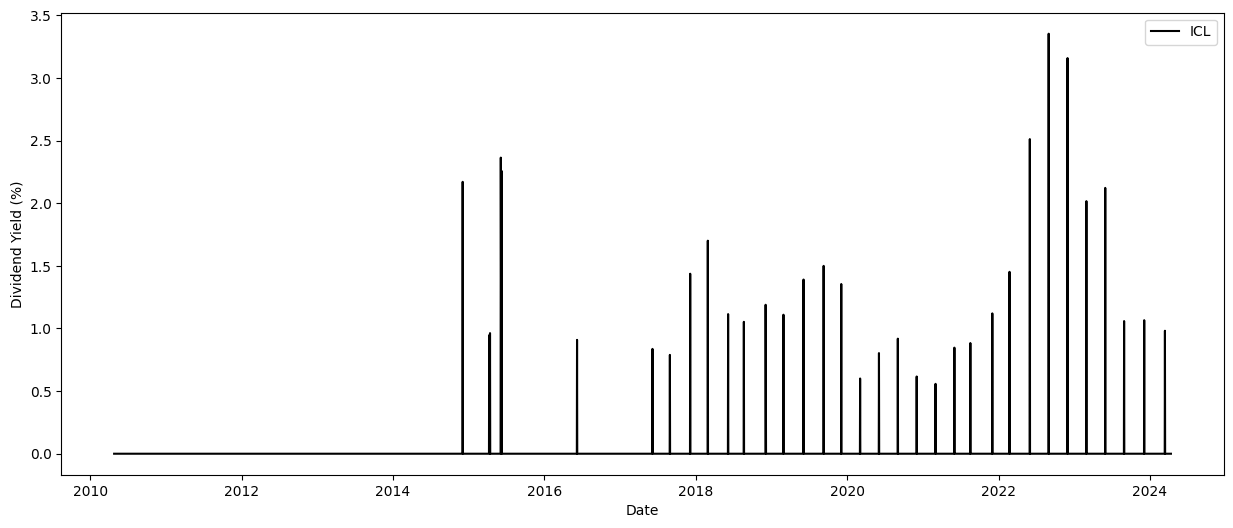

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   NaN
share_price     NaN
Name: share_price, dtype: float64


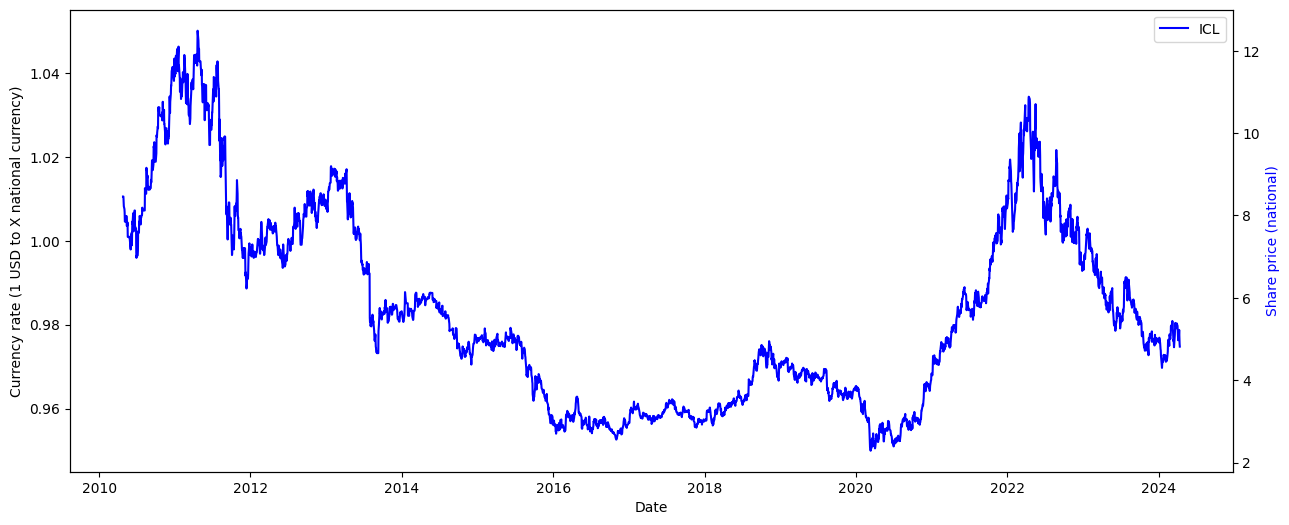

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

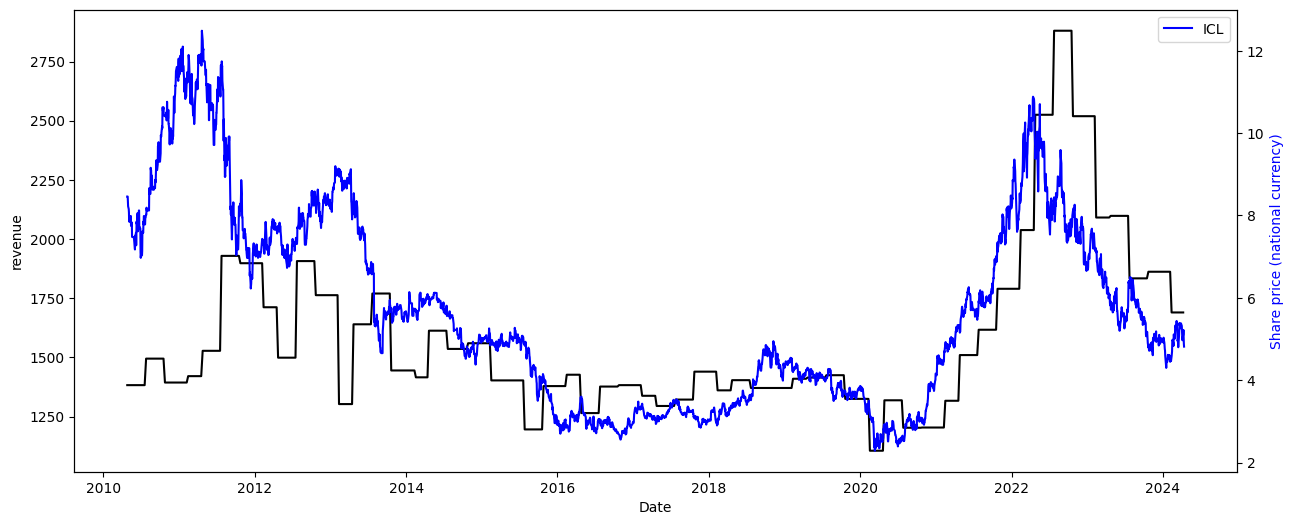

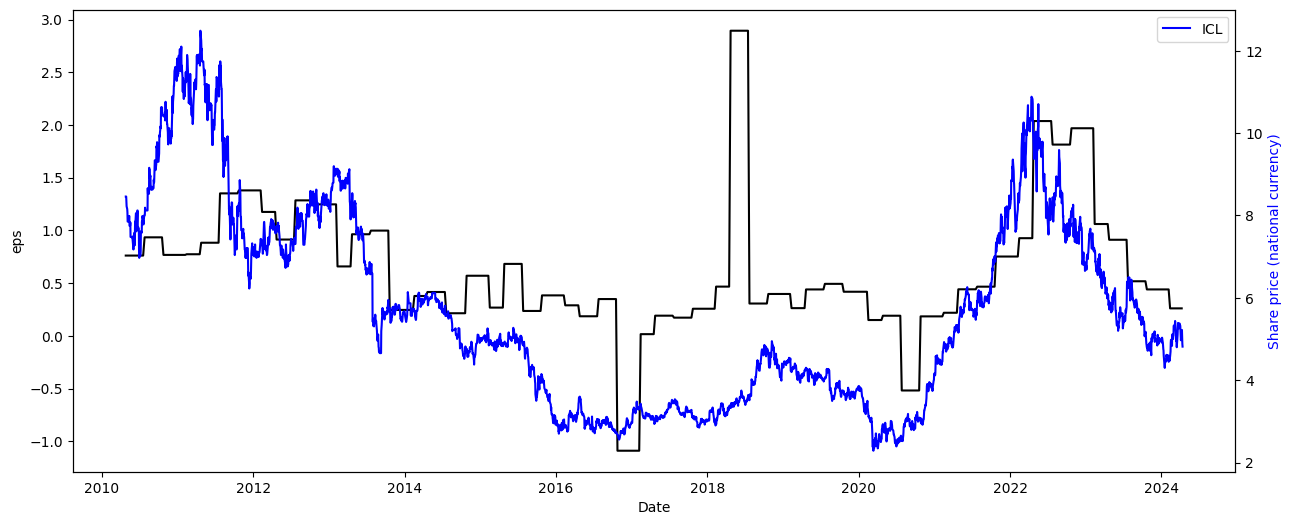

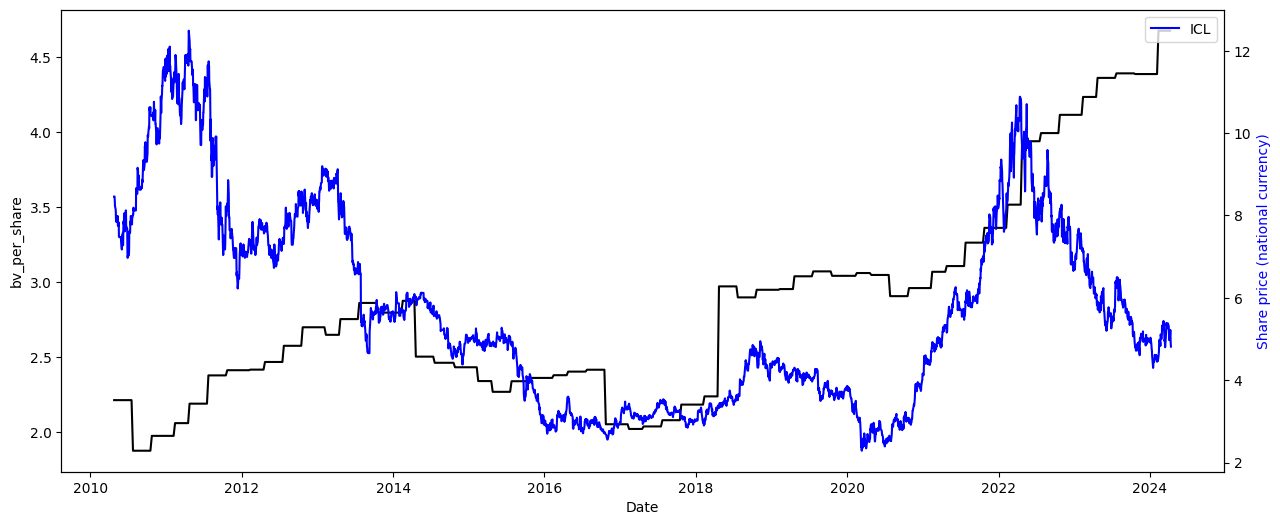

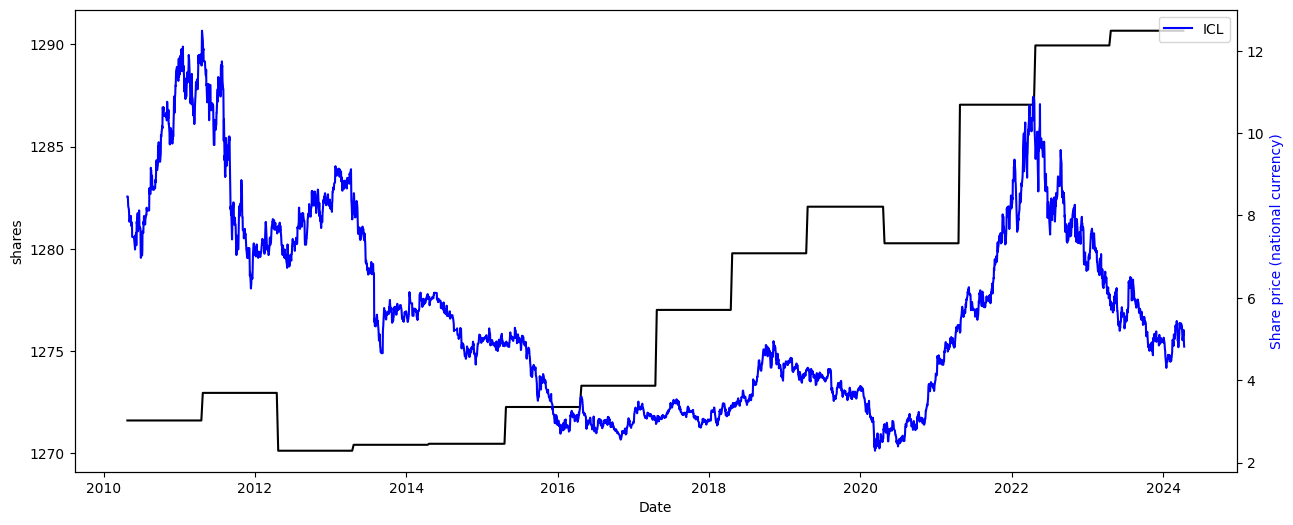

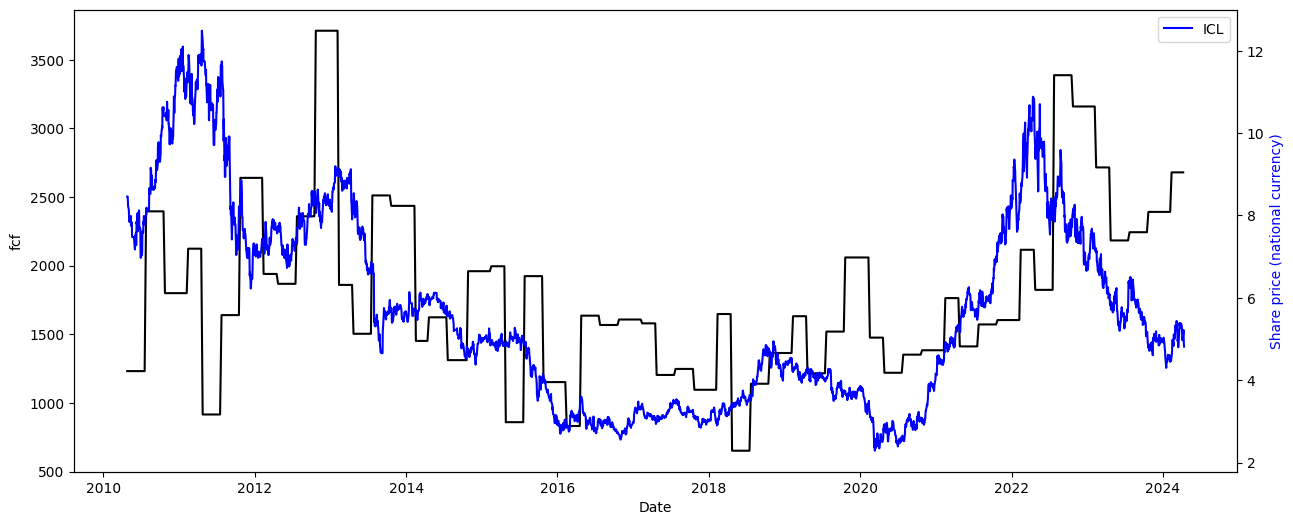

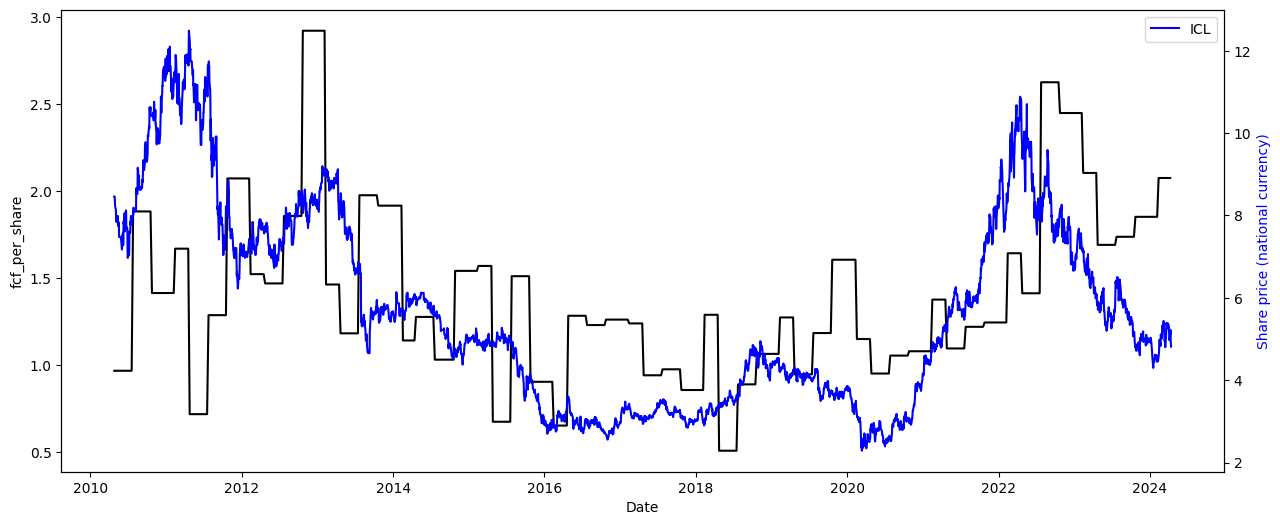

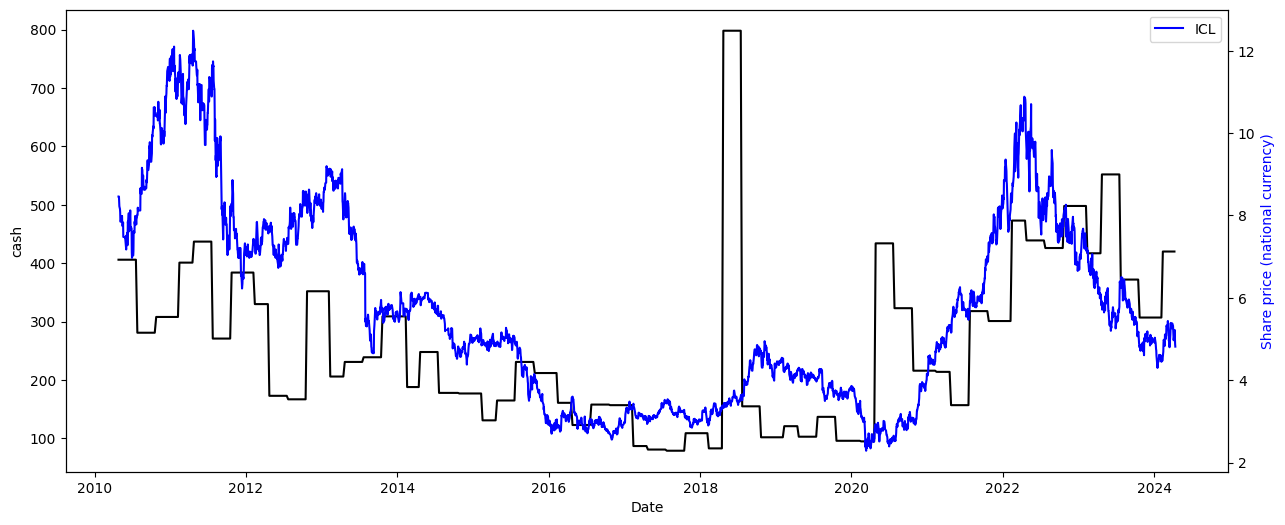

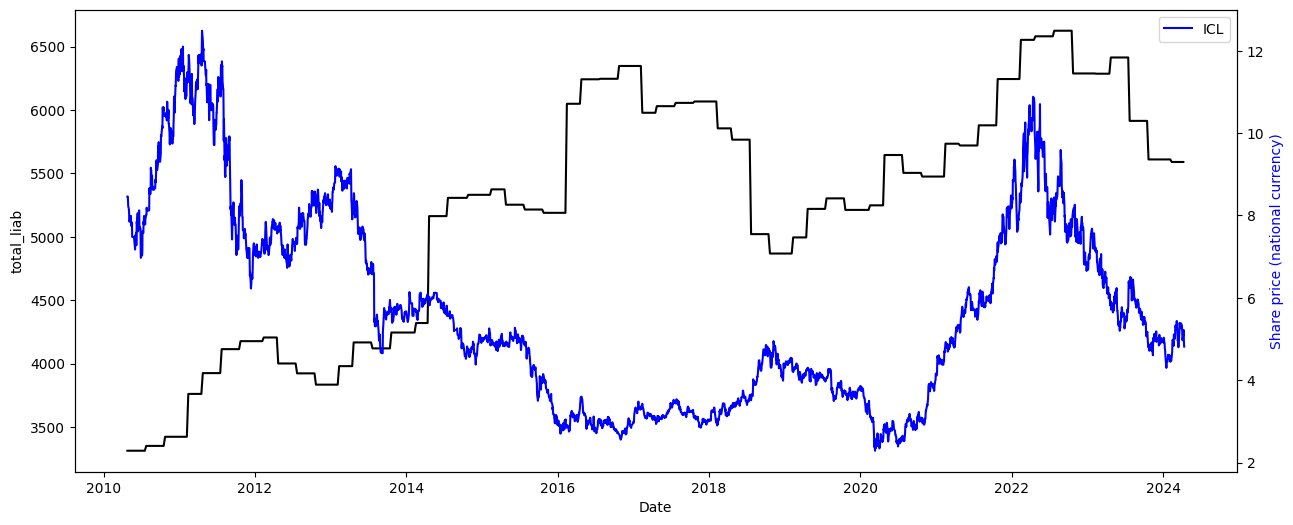

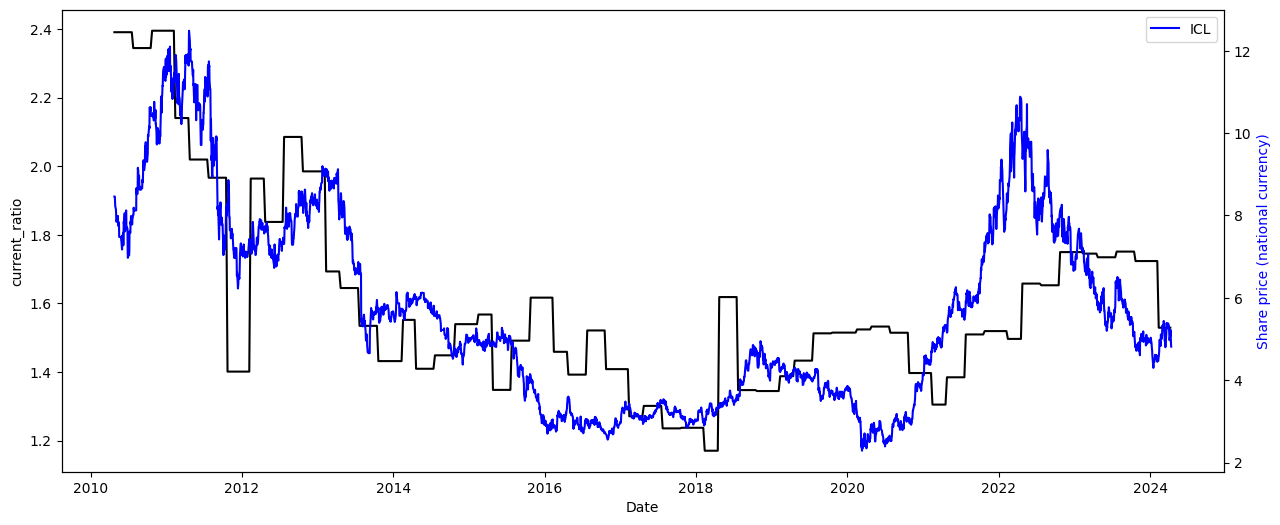

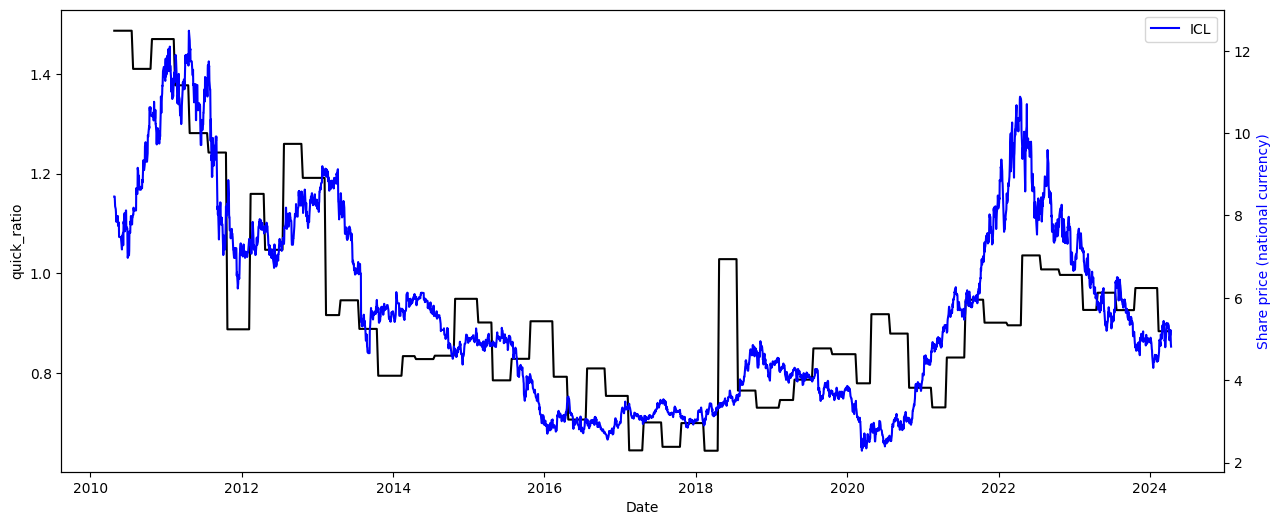

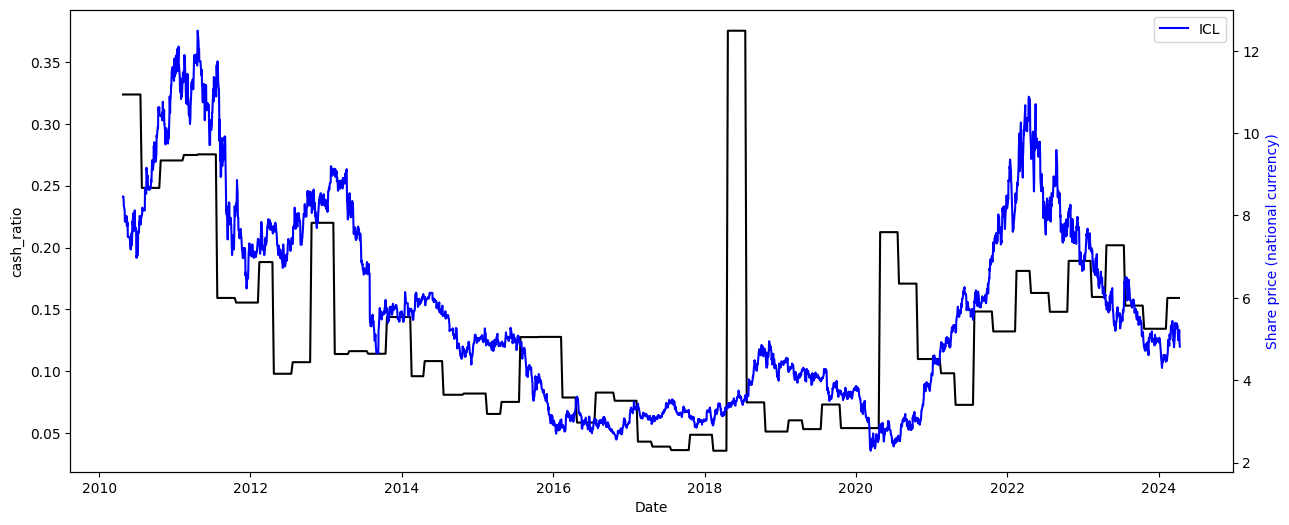

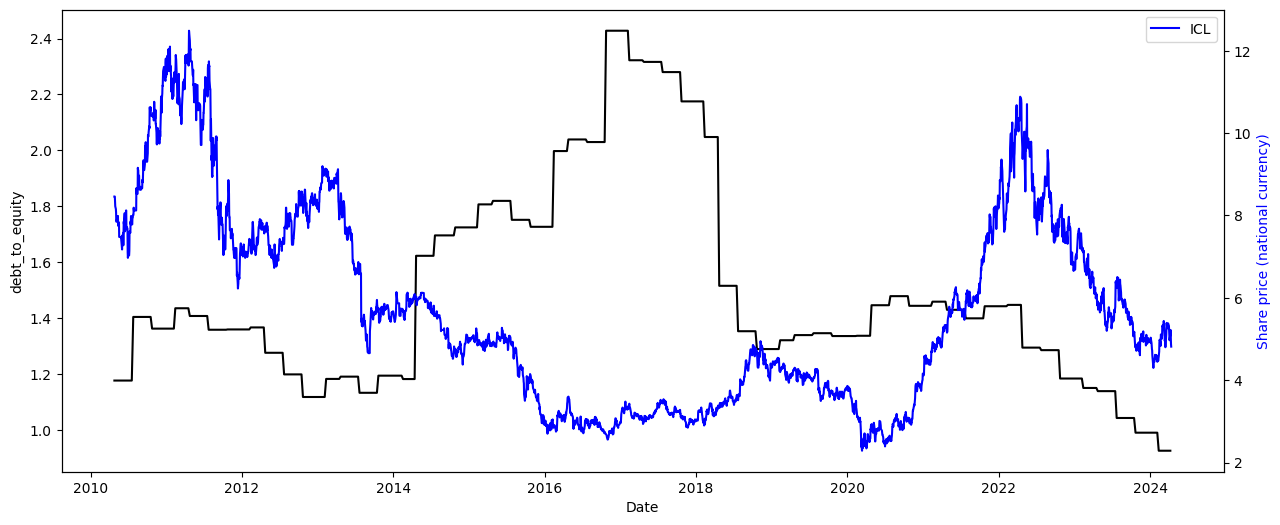

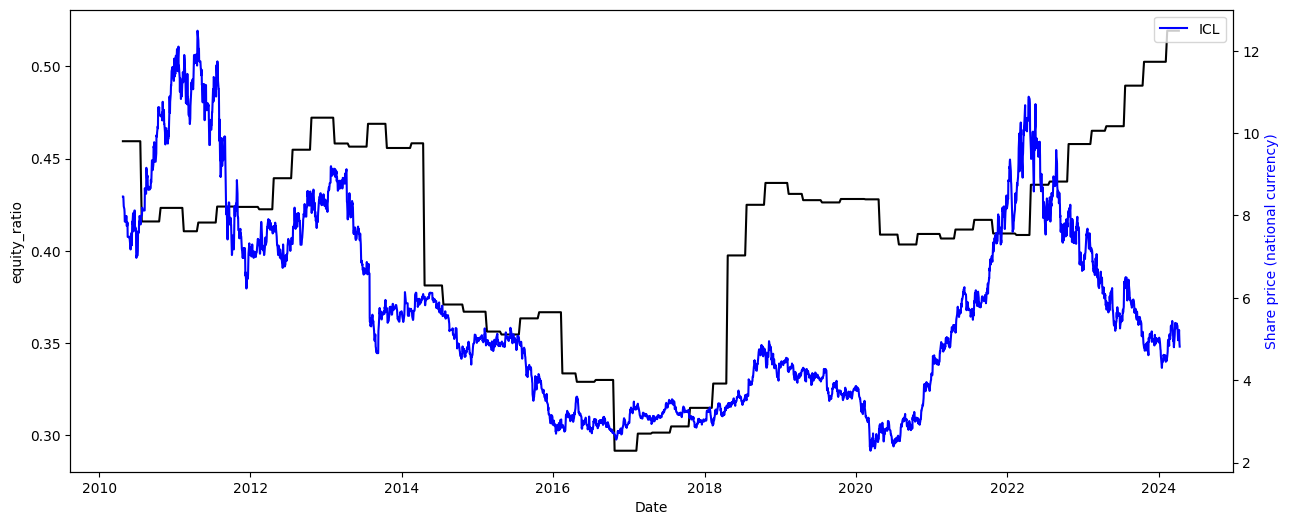

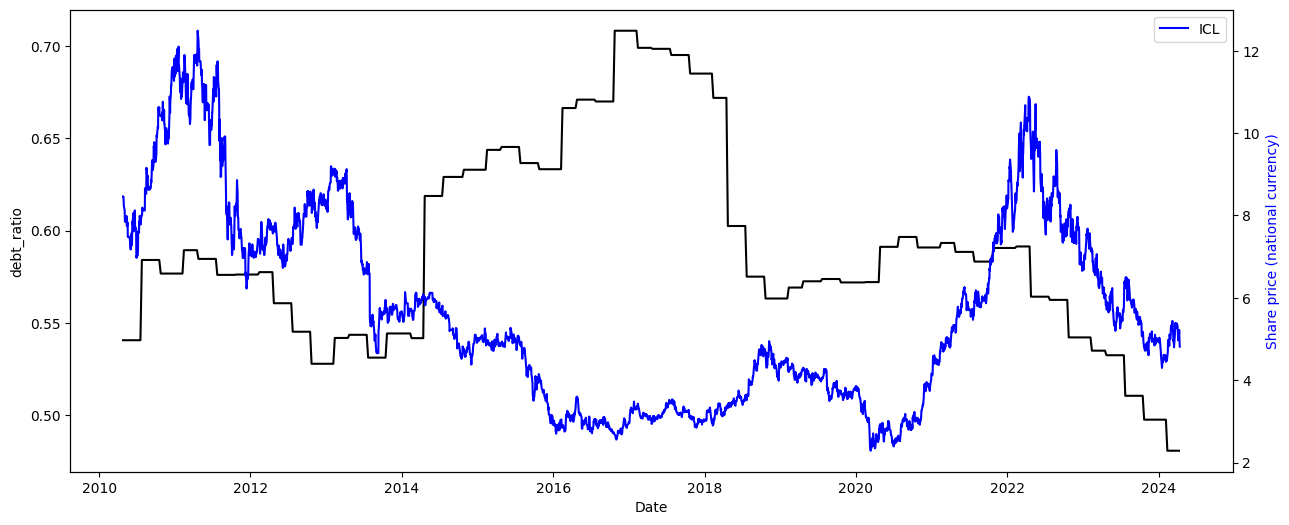

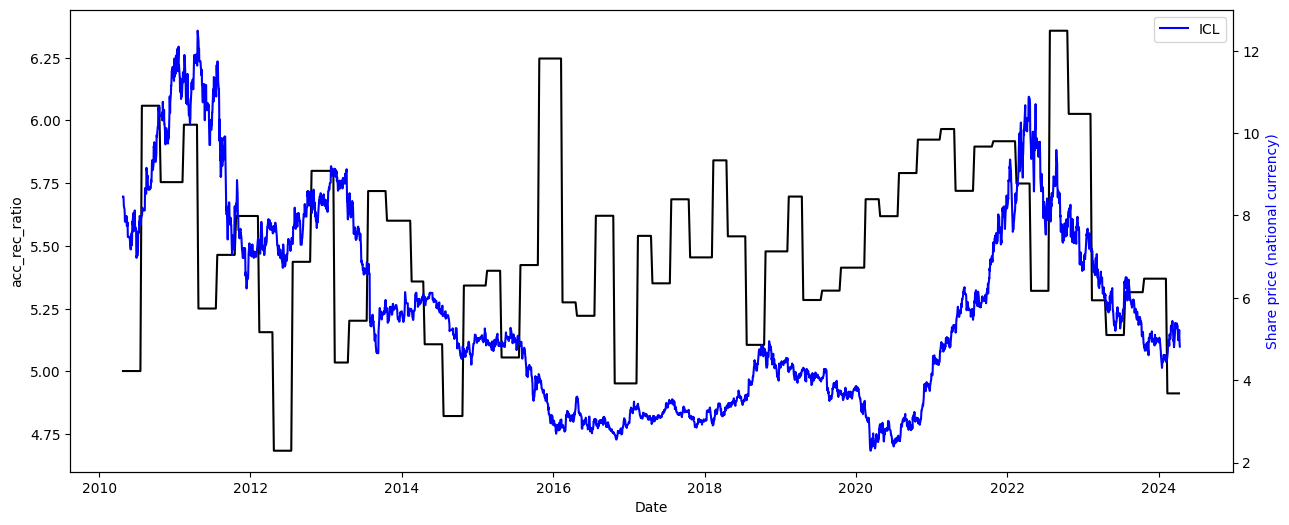

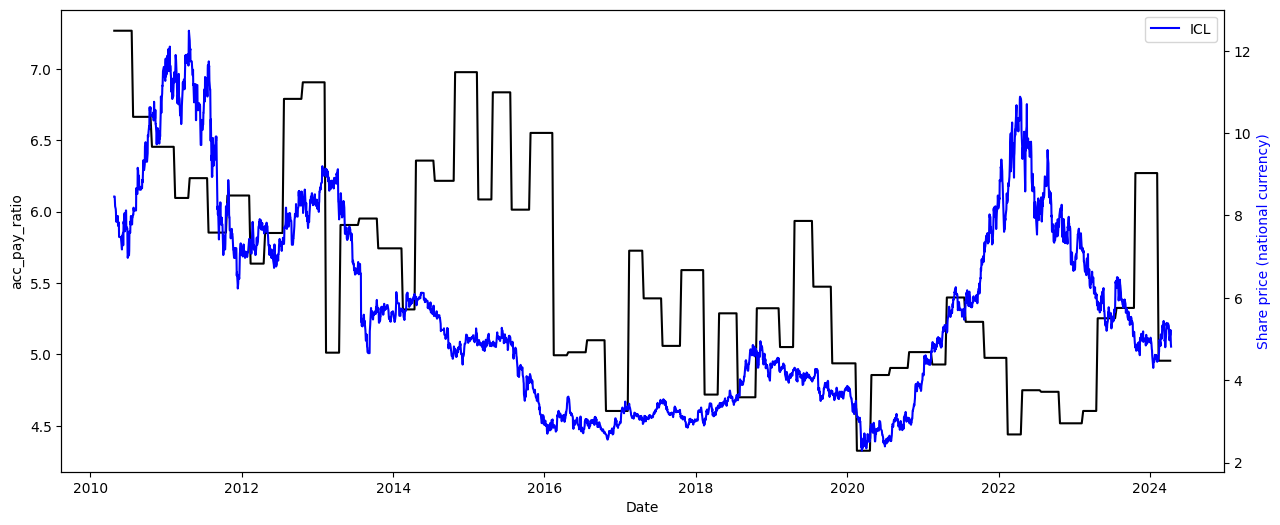

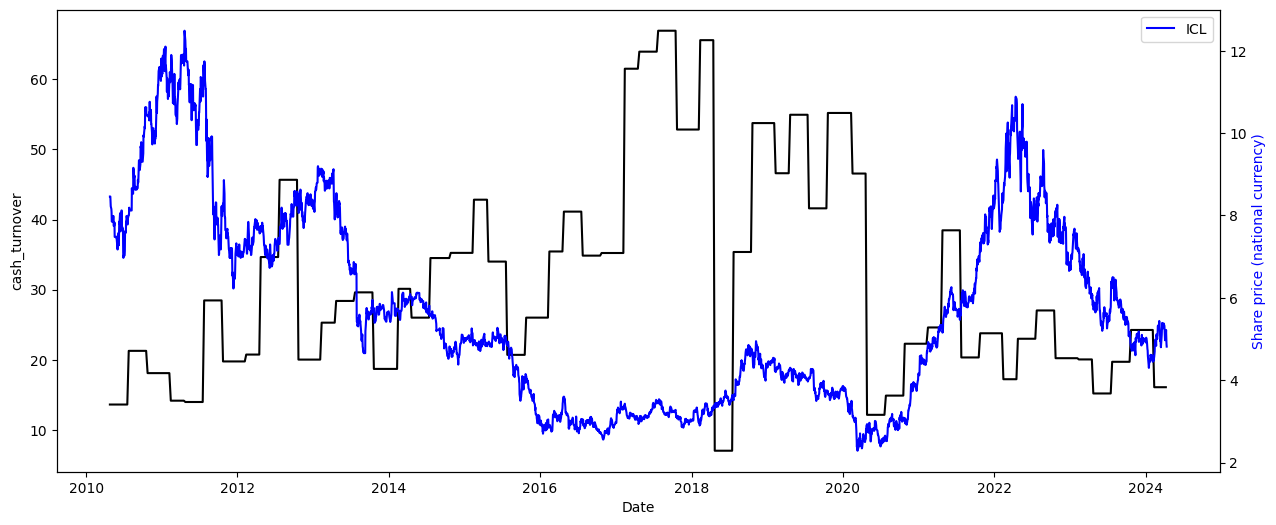

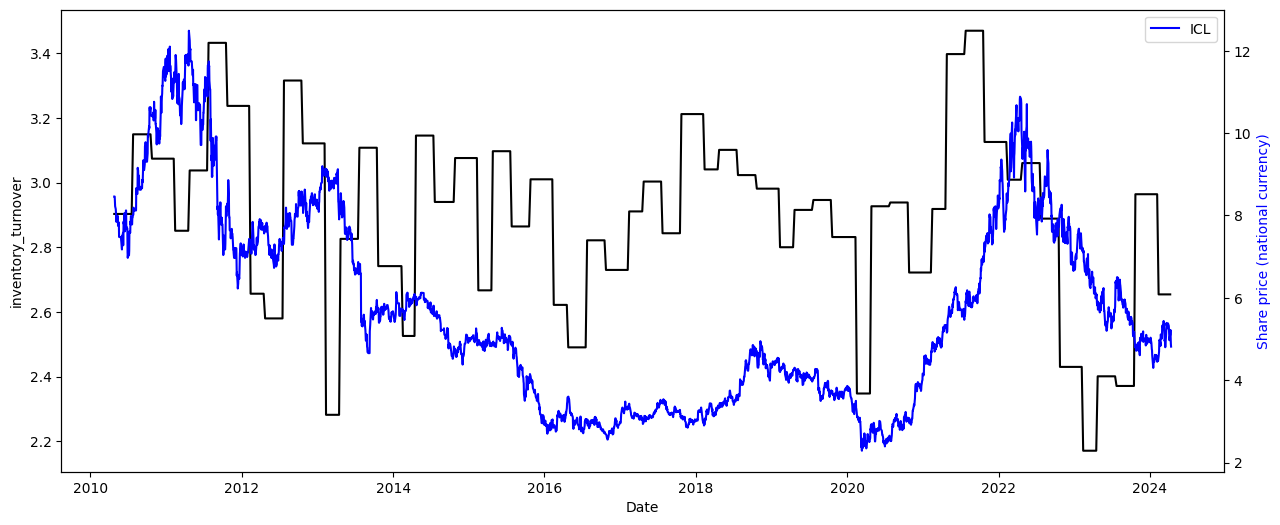

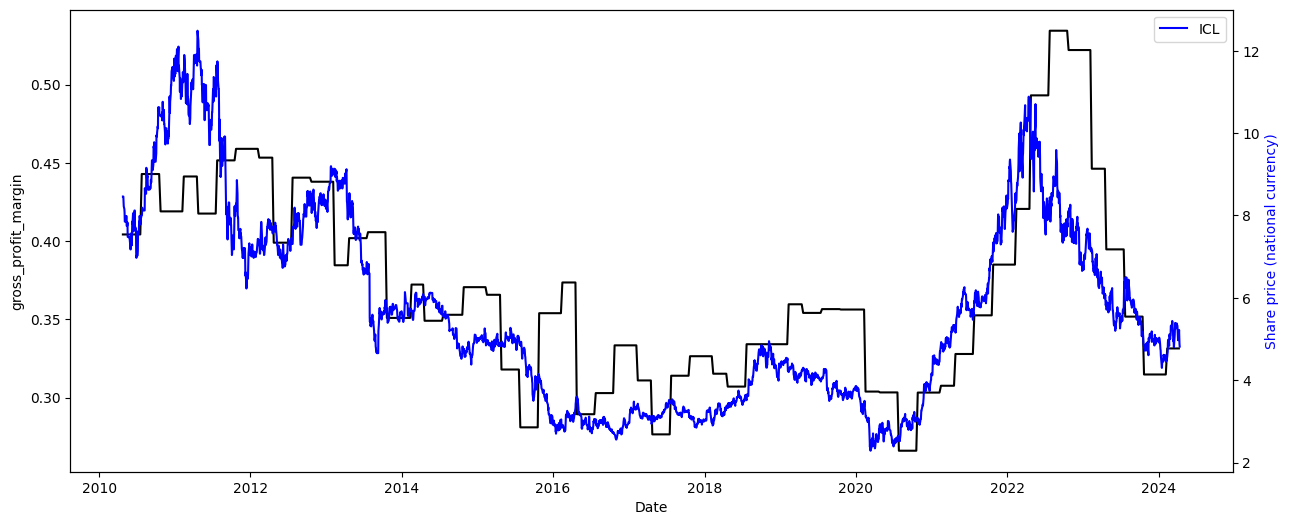

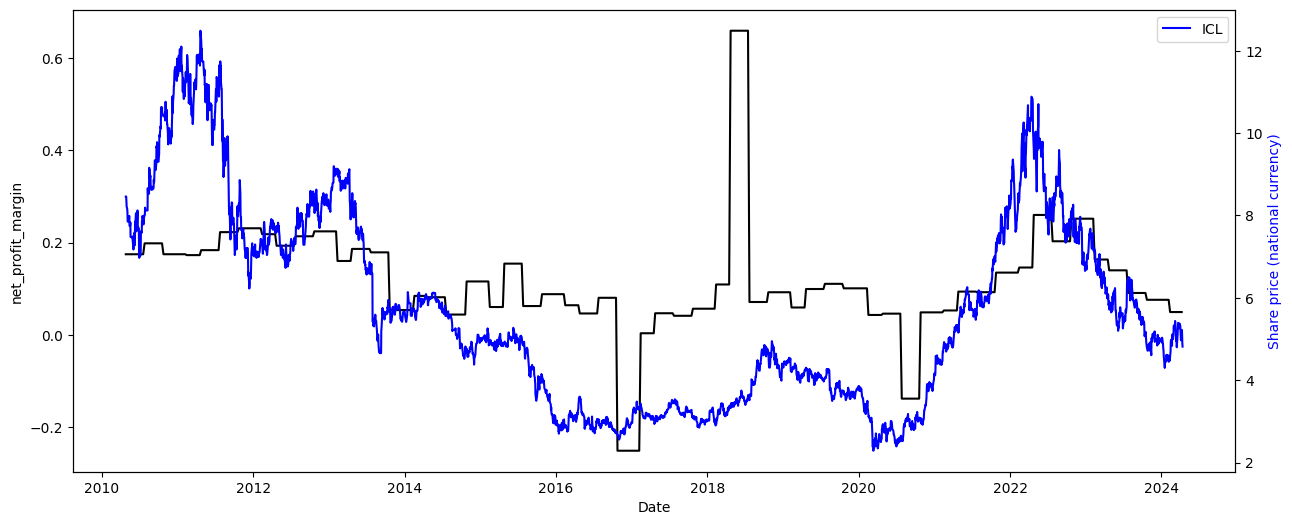

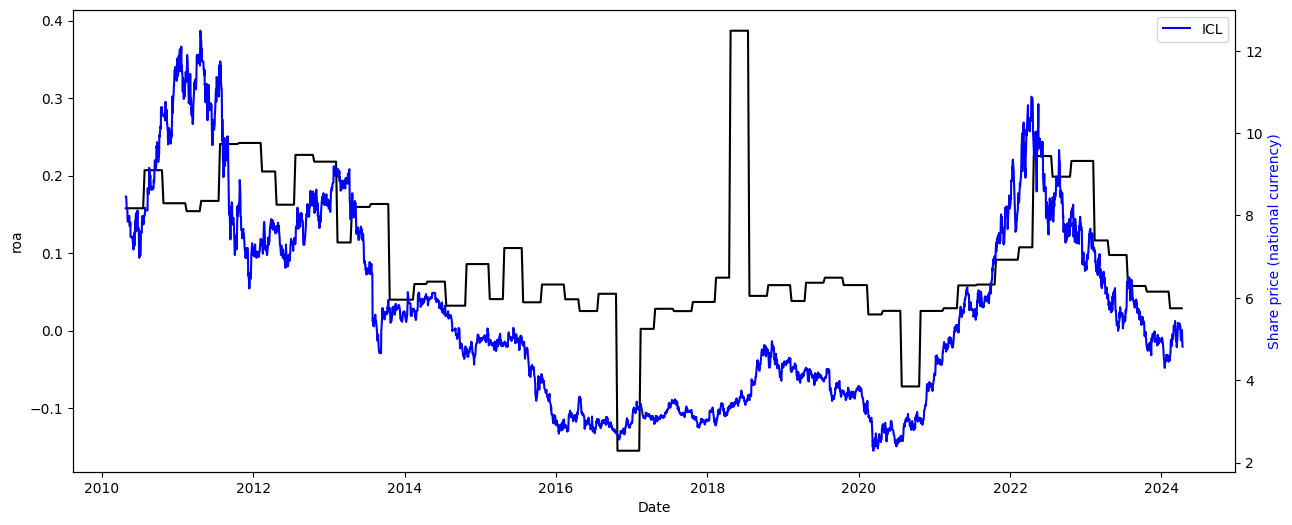

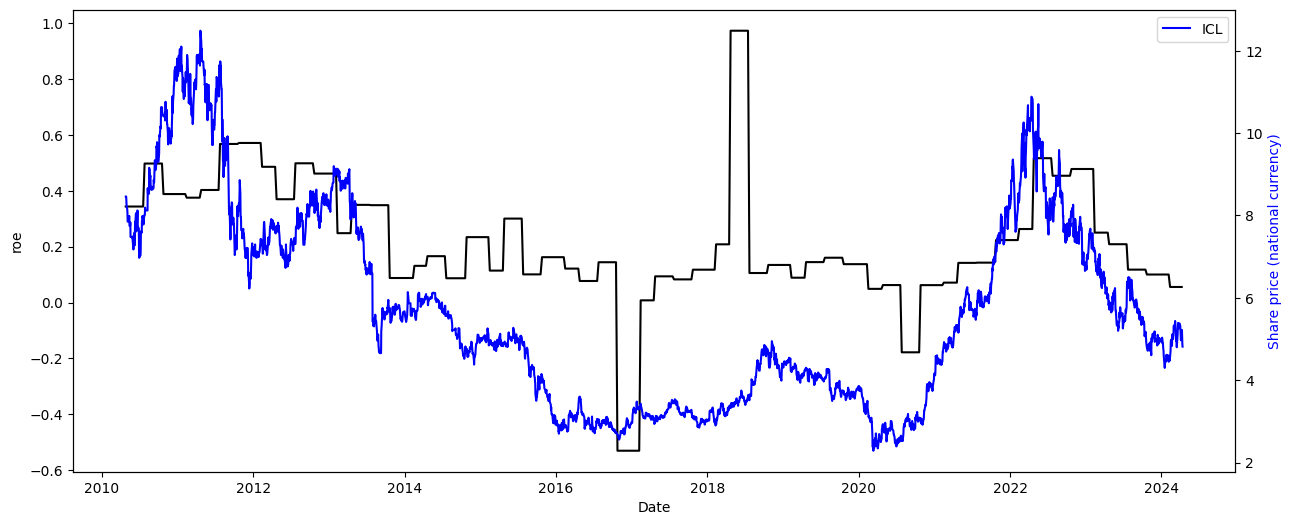

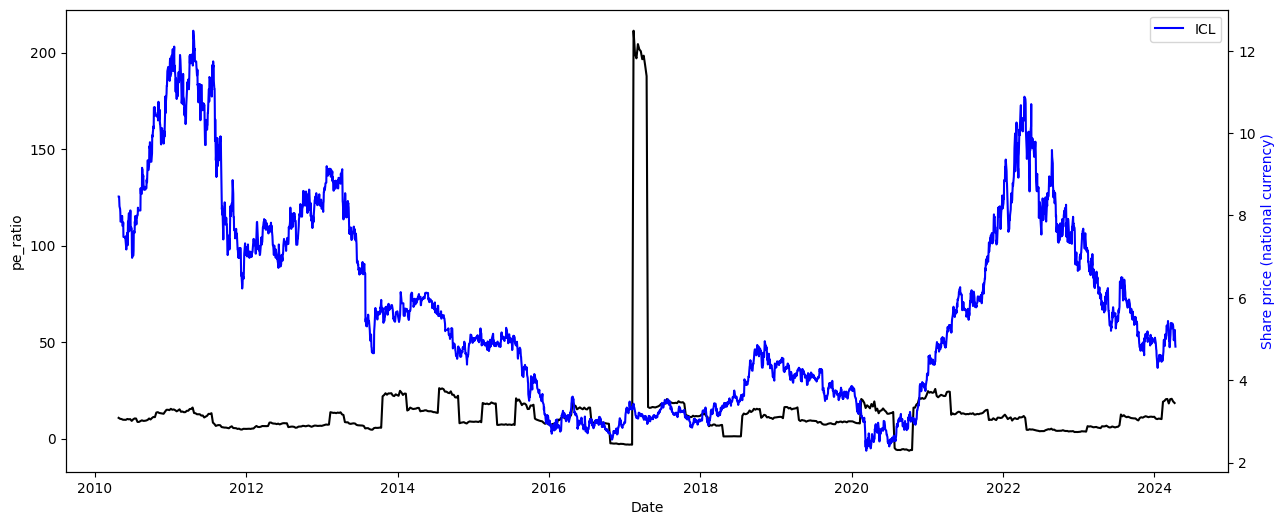

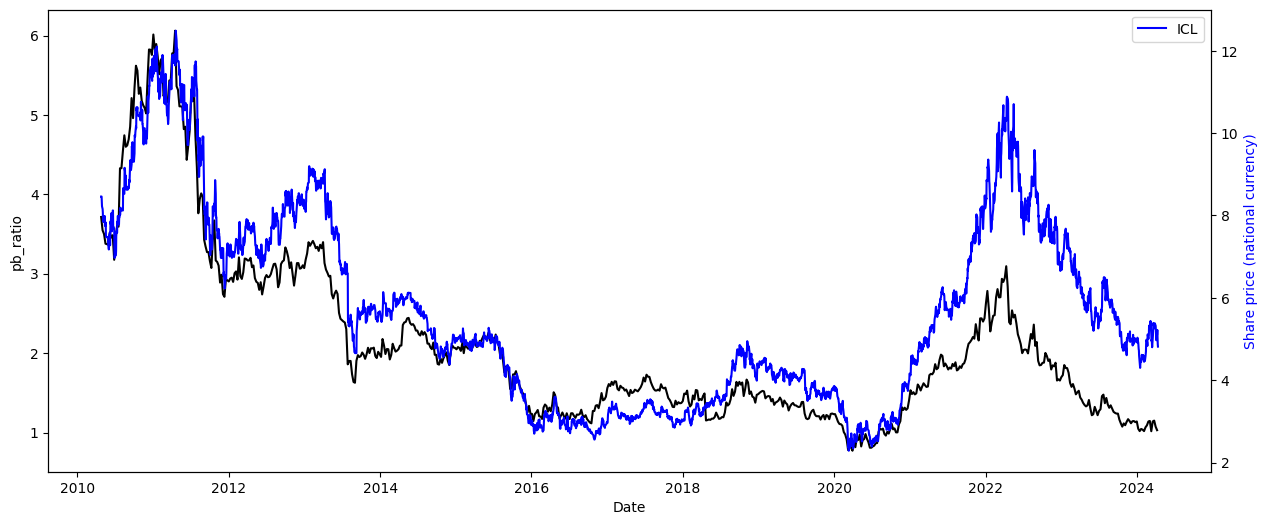

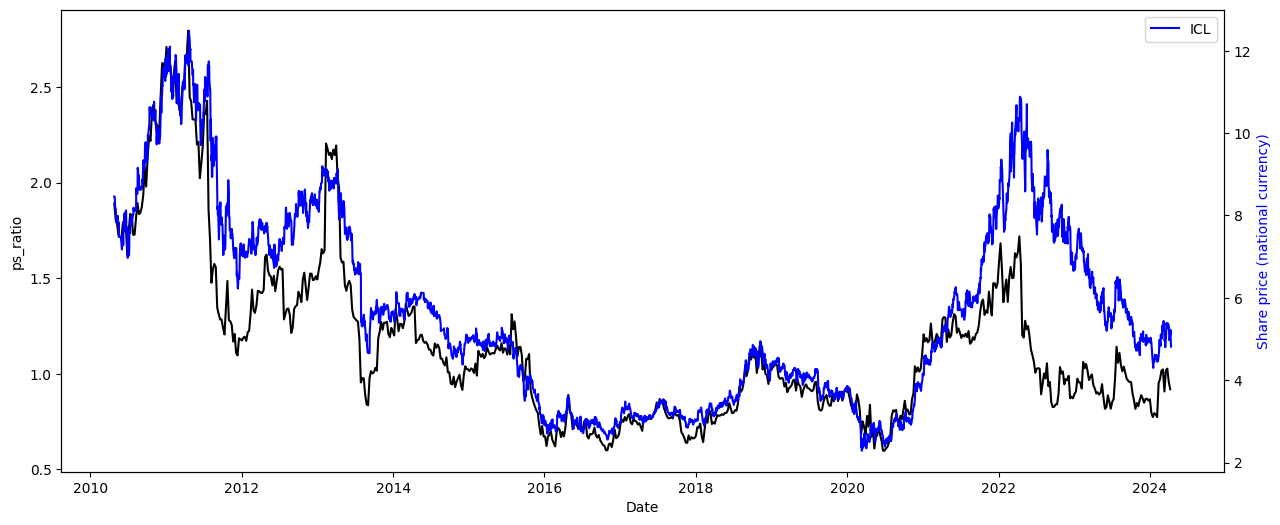

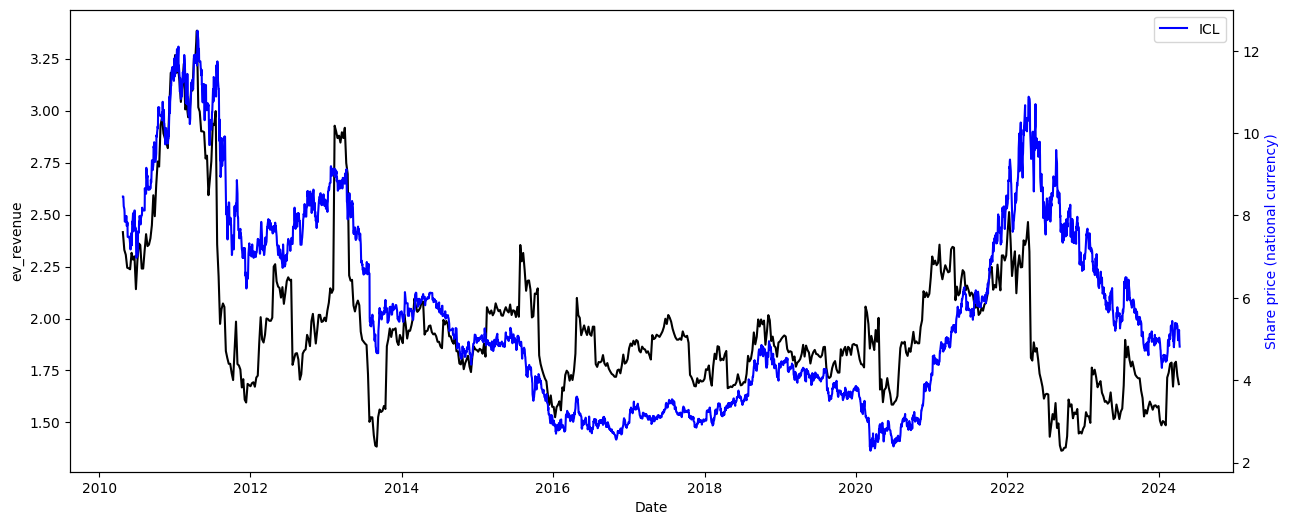

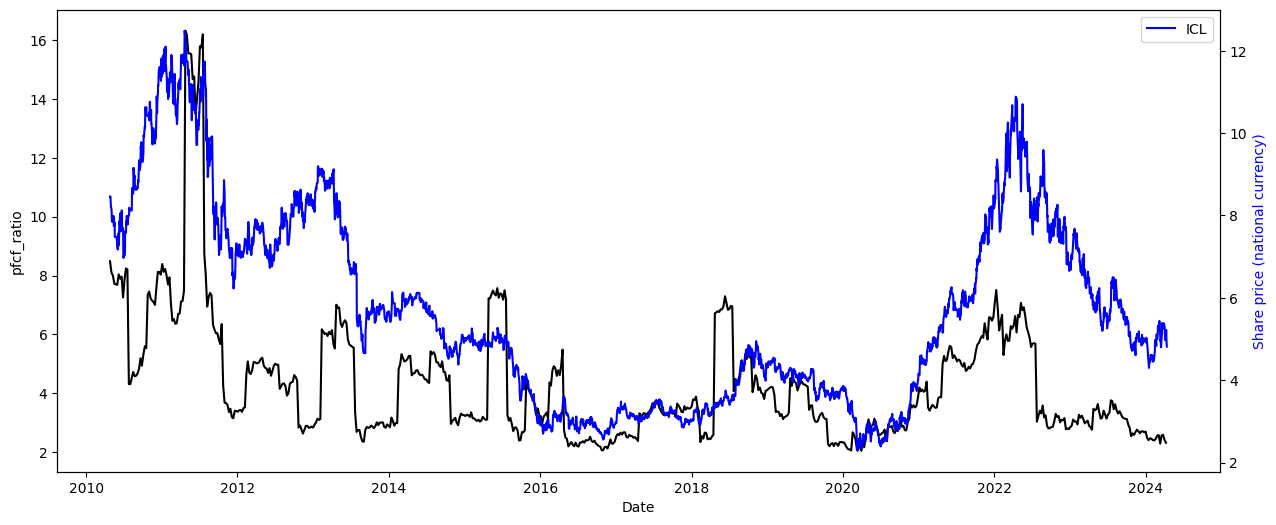

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

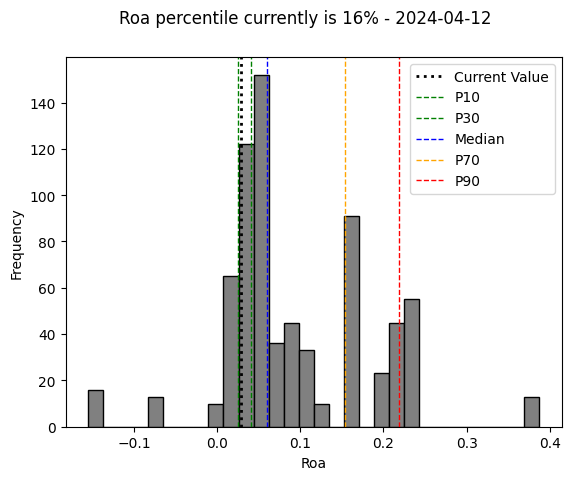

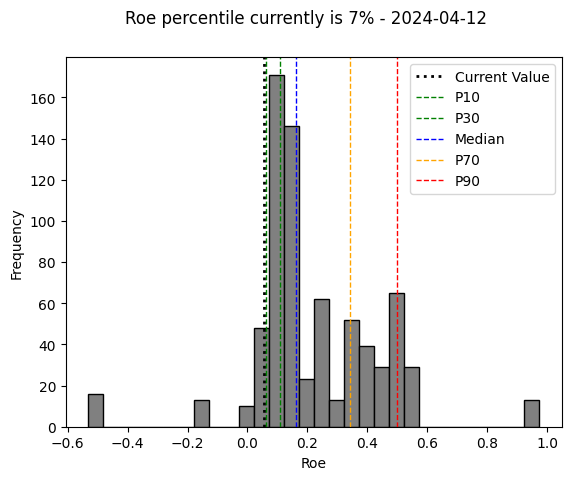

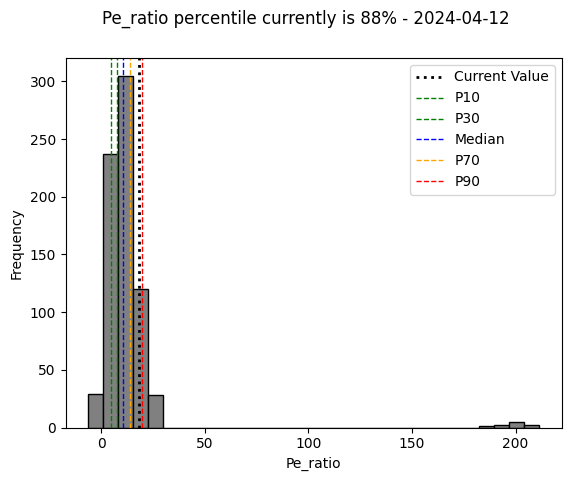

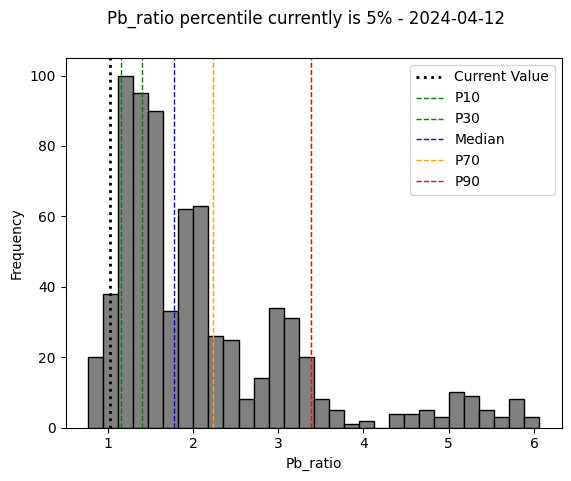

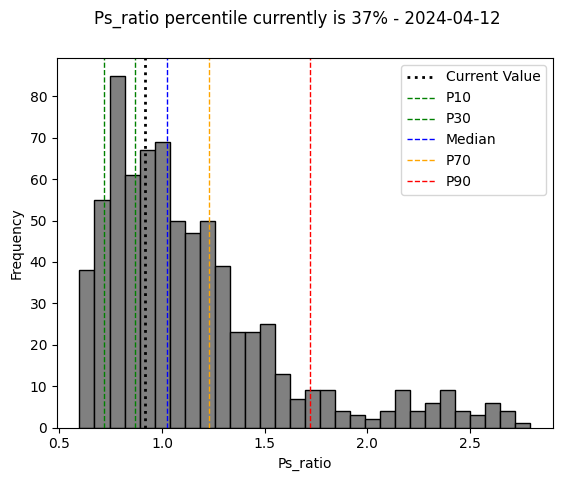

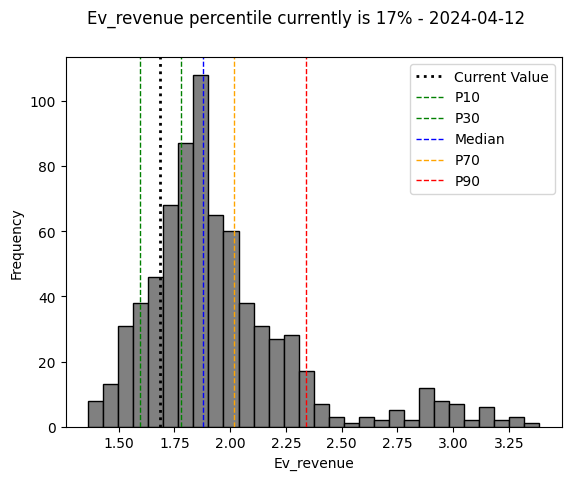

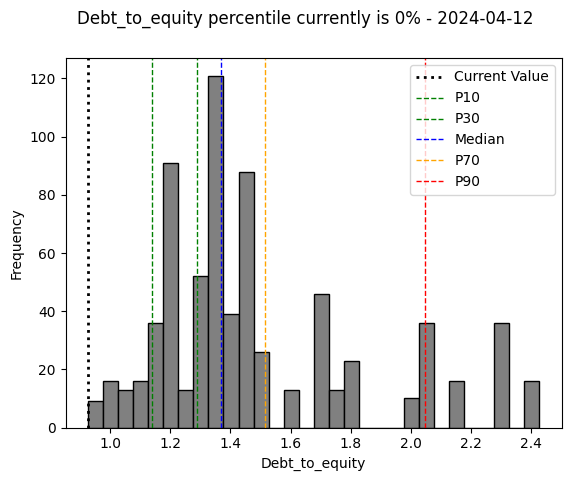

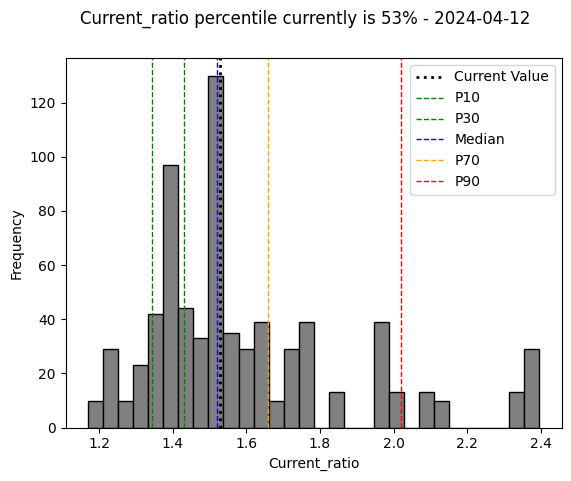

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.989332,-0.192620,0.515384,0.431808,0.094859,-0.463752,0.558155
roe,0.989332,1.000000,-0.168670,0.490564,0.410277,0.104955,-0.420536,0.506673
pe_ratio,-0.192620,-0.168670,1.000000,-0.051929,-0.061881,0.052195,0.272489,-0.183865
pb_ratio,0.515384,0.490564,-0.051929,1.000000,0.938796,0.775258,-0.212303,0.748664
ps_ratio,0.431808,0.410277,-0.061881,0.938796,1.000000,0.882112,-0.368083,0.710672
ev_revenue,0.094859,0.104955,0.052195,0.775258,0.882112,1.000000,-0.044466,0.460504
debt_to_equity,-0.463752,-0.420536,0.272489,-0.212303,-0.368083,-0.044466,1.000000,-0.476224
current_ratio,0.558155,0.506673,-0.183865,0.748664,0.710672,0.460504,-0.476224,1.000000


9 timestemos have been found!


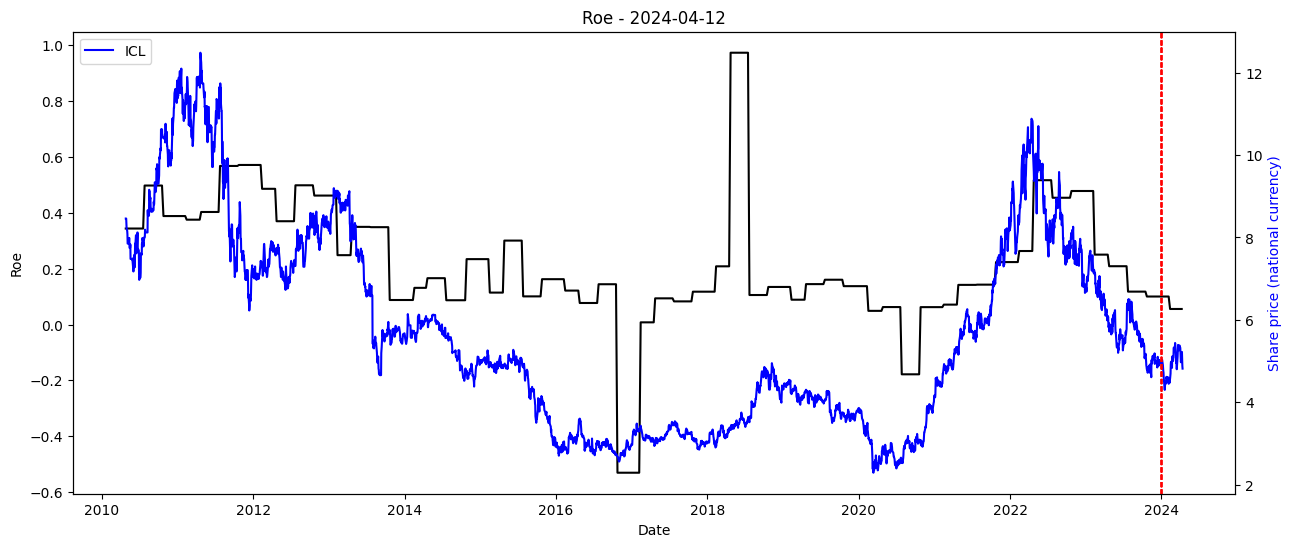

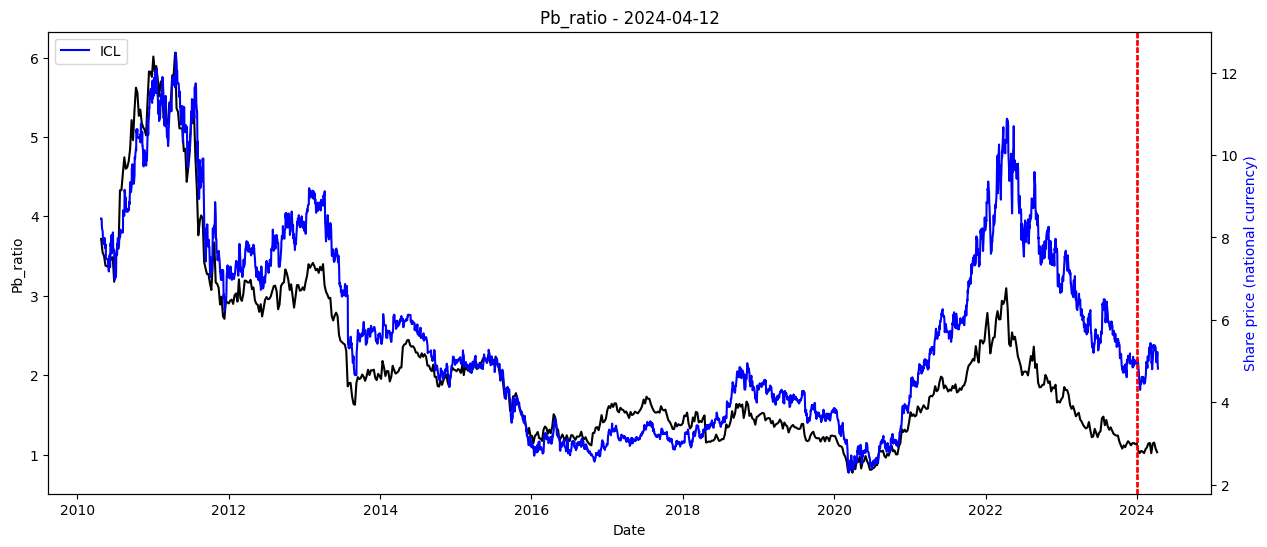

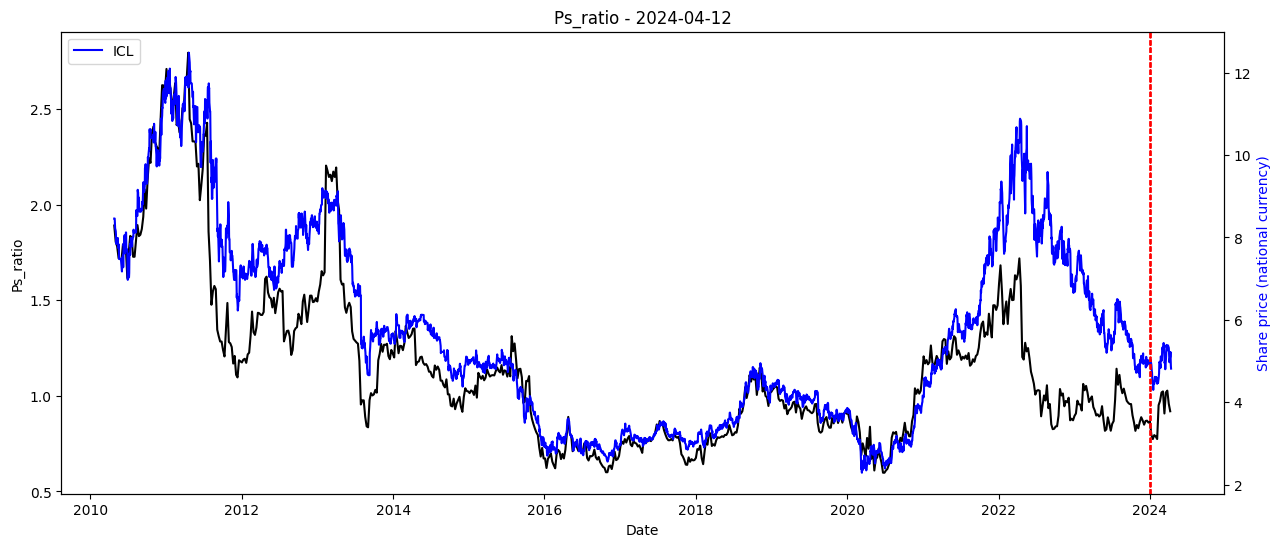

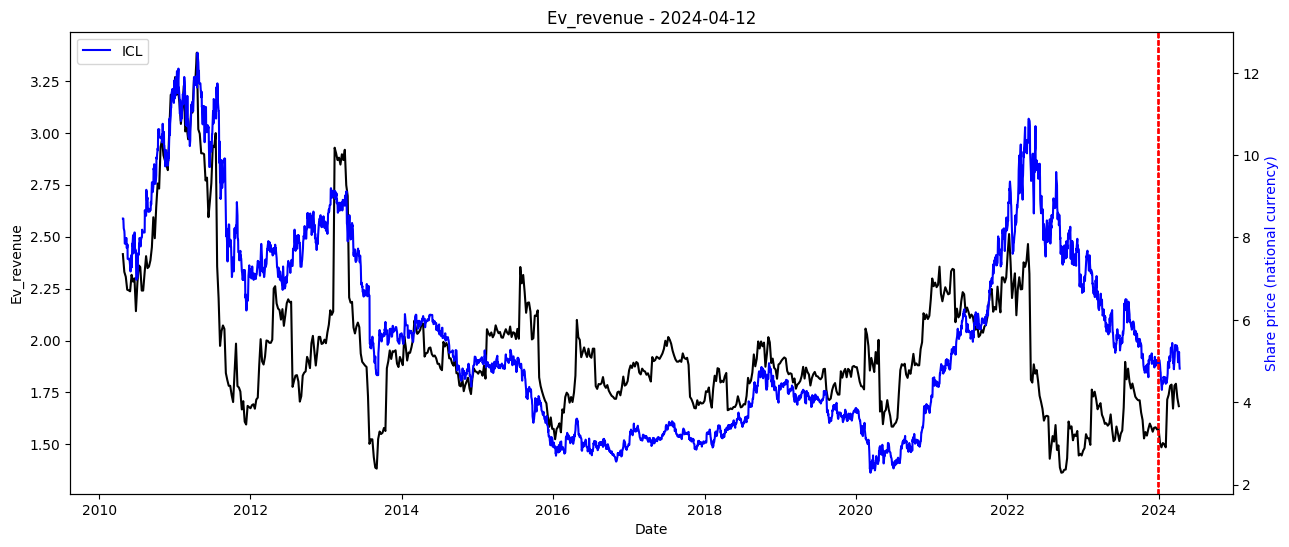

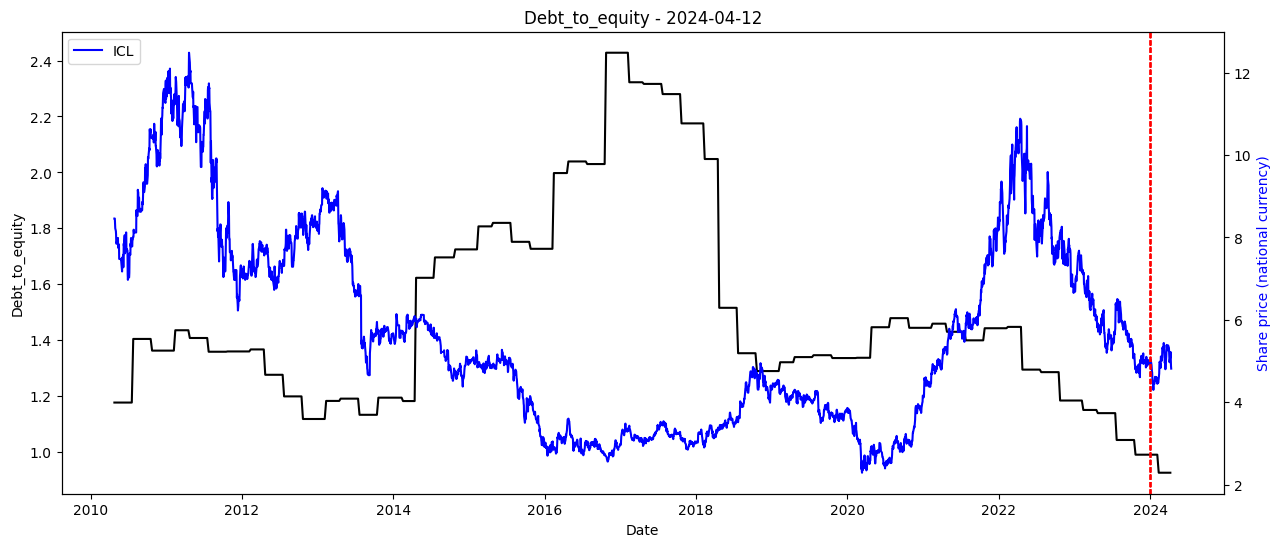

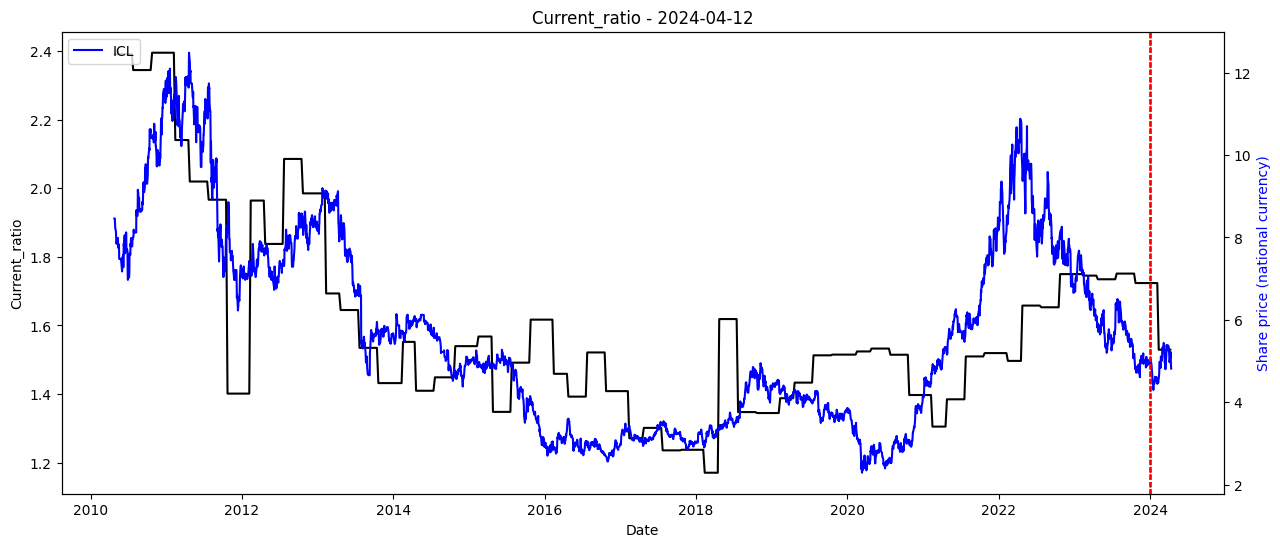

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )